<a href="https://colab.research.google.com/github/EnhanceImpact/income-classifier-app/blob/main/ACS_Data_Modeling_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Modeling

####Stratified K-Fold (n = 5)
* In 5-fold cross-validation, the data is split into five equal-sized folds.
* Each iteration uses 80% of the data for training and 20% for validation, rotating the test set each time.
* The “stratified” aspect ensures that each fold maintains the same class distribution as the full dataset.

In [1]:
#@title Imports and Setup
from pathlib import Path
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, classification_report, precision_recall_curve

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier


In [2]:
#@title Define Paths and Feature Lists
DATA_PATH = "/content/ACSPUMS1Y2022_Georgia_Data.csv"
MODEL_DIR = Path("model"); MODEL_DIR.mkdir(exist_ok=True)

CATEGORICAL = ["TEN","RAC1P","CIT","SCHL","BLD","HUPAC","COW","MAR","SEX","VEH","WKL"]
NUMERIC     = ["AGEP","NPF","GRPIP","WKHP"]
ALL_FEATS   = CATEGORICAL + NUMERIC
TARGET      = "income_>50K"


In [3]:
#@title Mapping Dictionaries
# These convert coded values into readable strings so models don't treat them as ordinal

# ---------- Mapping dicts (codes -> strings) ----------
marital_status_map = {1: "Married", 2: "Widowed", 3: "Divorced", 4: "Separated", 5: "Never married"}
citizenship_map    = {1: "Born in US", 2: "Born in Territory", 3: "Born abroad to US parents", 4: "Naturalized", 5: "Not a citizen"}
class_of_worker_map= {0: "Not Applicable", 1: "Private for-profit", 2: "Private nonprofit", 3: "Local government",
                      4: "State government", 5: "Self-employed"}
sex_map            = {1: "Male", 2: "Female"}
education_map      = {
    0:"N/A",1:"No schooling",2:"Pre-K to Grade 4",3:"Pre-K to Grade 4",4:"Pre-K to Grade 4",
    5:"Pre-K to Grade 4",6:"Pre-K to Grade 4",7:"Pre-K to Grade 4",8:"Grade 5-8",9:"Grade 5-8",
    10:"Grade 5-8",11:"Grade 5-8",12:"Grade 9-12 (no diploma)",13:"Grade 9-12 (no diploma)",
    14:"Grade 9-12 (no diploma)",15:"Grade 9-12 (no diploma)",16:"High School Graduate",17:"High School Graduate",
    18:"Some College",19:"Some College",20:"Associate's",21:"Bachelor's",22:"Graduate Degree",23:"Graduate Degree"
}
race_map           = {1:"White",2:"Black",3:"American Indian",4:"Alaska Native",5:"Tribes Specified",
                      6:"Asian",7:"Pacific Islander",8:"Other",9:"Two or More Races"}
tenure_map         = {0:"N/A",1:"Owned with mortgage or loan (include home equity loans)",2:"Owned Free And Clear",
                      3:"Rented",4:"Occupied without payment of rent"}
building_map       = {0:"N/A",1:"Mobile Home or Trailer",2:"One-family house detached",3:"One-family house attached",
                      4:"2 Apartments",5:"3-4 Apartments",6:"5-9 Apartments",7:"10-19 Apartments",
                      8:"20-49 Apartments",9:"50 or More Apartments",10:"Boat, RV, van, etc."}
children_map       = {0:"N/A",1:"With children under 6 years only",2:"With children 6 to 17 years only",
                      3:"With children under 6 years and 6 to 17 years",4:"No children"}
vehicle_map        = {-1:"N/A",0:"No vehicles",1:"1 vehicle",2:"2 vehicles",3:"3 vehicles",
                      4:"4 vehicles",5:"5 vehicles",6:"6 or more vehicles"}



In [4]:
#@title Mapping and Imputation Function

def _map_if_numeric(series, mapping):
    # Treat numeric-coded categoricals as nominal: map codes -> strings, else leave strings as-is
    if pd.api.types.is_integer_dtype(series) or pd.api.types.is_float_dtype(series):
        return series.map(mapping)
    return series

def mapping_impute(df: pd.DataFrame) -> pd.DataFrame:
    """
    - Map numeric codes -> strings for all categorical columns (prevents models treating codes as ordinal).
    - Drop 'ST' if present.
    - Impute: object cols by mode; numeric cols by median.
    - Ensure declared numeric columns are numeric dtype.
    """
    X = df.copy()

    # Map codes -> strings for categoricals (idempotent if already strings)
    if "MAR"   in X: X["MAR"]   = _map_if_numeric(X["MAR"],   marital_status_map)
    if "CIT"   in X: X["CIT"]   = _map_if_numeric(X["CIT"],   citizenship_map)
    if "COW"   in X: X["COW"]   = _map_if_numeric(X["COW"],   class_of_worker_map)
    if "SEX"   in X: X["SEX"]   = _map_if_numeric(X["SEX"],   sex_map)
    if "SCHL"  in X: X["SCHL"]  = _map_if_numeric(X["SCHL"],  education_map)
    if "RAC1P" in X: X["RAC1P"] = _map_if_numeric(X["RAC1P"], race_map)
    if "TEN"   in X: X["TEN"]   = _map_if_numeric(X["TEN"],   tenure_map)
    if "BLD"   in X: X["BLD"]   = _map_if_numeric(X["BLD"],   building_map)
    if "HUPAC" in X: X["HUPAC"] = _map_if_numeric(X["HUPAC"], children_map)
    if "VEH"   in X: X["VEH"]   = _map_if_numeric(X["VEH"],   vehicle_map)

    # Drop unused if present
    X.drop(columns=["ST"], errors="ignore", inplace=True)

    # Ensure numeric cols really numeric (in case read as strings)
    for c in NUMERIC:
        if c in X:
            X[c] = pd.to_numeric(X[c], errors="coerce")

    # Impute by type
    obj_cols = X.select_dtypes(include="object").columns
    for c in obj_cols:
        mode = X[c].mode(dropna=True)
        X[c] = X[c].fillna(mode.iloc[0] if not mode.empty else "Unknown")

    num_cols = X.select_dtypes(include=[np.number]).columns
    for c in num_cols:
        med = X[c].median()
        X[c] = X[c].fillna(0 if np.isnan(med) else med)

    return X

In [5]:
#@title Wrap Mapping in a Transformer
mapper = FunctionTransformer(mapping_impute, feature_names_out="one-to-one", validate=False)

In [6]:
#@title Load and Prepare Data

df_raw = pd.read_csv(DATA_PATH)

# Keep it simple: only filter by age >= 16 (no other restrictions)
df = df_raw.loc[df_raw["AGEP"] >= 16].copy()

if TARGET not in df.columns:
    if "WAGP" not in df.columns:
        raise ValueError("Need WAGP in CSV to derive target or include income_>50K directly.")
    df[TARGET] = (df["WAGP"].astype(float) > 50000).astype(int)

missing = set(ALL_FEATS + [TARGET]) - set(df.columns)
if missing:
    raise ValueError(f"Missing required columns in CSV: {missing}")

X = df[ALL_FEATS].copy()
y = df[TARGET].astype(int).copy()

In [7]:
#@title Train/Validation Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, stratify=y, random_state=42
)


In [8]:
#@title Preprocessing Pipelines
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

cat_pipe = Pipeline([
    ("impute", SimpleImputer(strategy="most_frequent")),
    ("ohe", ohe)
])
num_pipe_noscale = Pipeline([
    ("impute", SimpleImputer(strategy="median"))
])
pre_base = ColumnTransformer([
    ("cat", cat_pipe, CATEGORICAL),
    ("num", num_pipe_noscale, NUMERIC)
])

# For LR: scale numerics after impute/OHE
num_pipe_scaled = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("scale", StandardScaler())
])
pre_for_lr = ColumnTransformer([
    ("cat", cat_pipe, CATEGORICAL),
    ("num", num_pipe_scaled, NUMERIC)
])

In [9]:
#@title Handles Class imbalance for XGBoost
# ---------- Class imbalance helper ----------
pos = int((y_train == 1).sum())
neg = int((y_train == 0).sum())
scale_pos_weight = neg / max(pos, 1)  # for XGB





In [10]:
#@title Build Model Pipelines (includes mapping step)

pipe_lr = Pipeline([
    ("map_impute", mapper),
    ("pre", pre_for_lr),
    ("clf", LogisticRegression(class_weight="balanced", max_iter=2000, n_jobs=-1))
])

pipe_rf = Pipeline([
    ("map_impute", mapper),
    ("pre", pre_base),
    ("clf", RandomForestClassifier(class_weight="balanced", random_state=42, n_jobs=1))  # n_jobs=1 avoids nested-parallel warnings
])

pipe_xgb = Pipeline([
    ("map_impute", mapper),
    ("pre", pre_base),
    ("clf", XGBClassifier(
        random_state=42,
        eval_metric="logloss",
        n_estimators=100,
        max_depth=6,
        scale_pos_weight=scale_pos_weight,
        tree_method="hist",
        n_jobs=1   # let GridSearch parallelize
    ))
])




In [11]:
#@title Define Hyperparameter Grids

grid_lr  = {"clf__C": [0.1, 1, 10]}
grid_rf  = {"clf__n_estimators": [200, 300],
            "clf__max_depth": [None, 20, 30]}
grid_xgb = {"clf__n_estimators": [100, 200],
            "clf__max_depth": [6, 9]}

In [12]:
#@title Cross Validation and Grid Search
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = "roc_auc"   # better than accuracy for imbalanced problems

def run_grid(name, pipe, grid):
    print(f"\n=== {name} ===")
    gs = GridSearchCV(pipe, grid, cv=cv, scoring=scorer, n_jobs=-1)
    gs.fit(X_train, y_train)
    print("Best", scorer, ":", gs.best_score_)
    print("Best Params:", gs.best_params_)
    # Evaluate on hold-out validation (same preprocessing via pipeline)
    y_prob = gs.best_estimator_.predict_proba(X_val)[:, 1]
    print("Hold-out ROC-AUC:", roc_auc_score(y_val, y_prob))
    return gs, y_prob



In [13]:
#@title Model Selection
gs_lr,  prob_lr  = run_grid("Logistic Regression", pipe_lr, grid_lr)
gs_rf,  prob_rf  = run_grid("Random Forest",       pipe_rf, grid_rf)
gs_xgb, prob_xgb = run_grid("XGBoost",             pipe_xgb, grid_xgb)



=== Logistic Regression ===
Best roc_auc : 0.9238175058698646
Best Params: {'clf__C': 10}
Hold-out ROC-AUC: 0.9284702773485939

=== Random Forest ===


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best roc_auc : 0.933039029363175
Best Params: {'clf__max_depth': 20, 'clf__n_estimators': 300}
Hold-out ROC-AUC: 0.936443900471054

=== XGBoost ===
Best roc_auc : 0.9355130719112552
Best Params: {'clf__max_depth': 6, 'clf__n_estimators': 100}
Hold-out ROC-AUC: 0.9404380306005007


In [14]:
#@title Select the Best Model by Hold-Out ROC-AUC

candidates = [
    ("logreg", gs_lr,  prob_lr),
    ("rf",     gs_rf,  prob_rf),
    ("xgb",    gs_xgb, prob_xgb),
]
best_name, best_gs, best_prob = max(
    candidates, key=lambda t: roc_auc_score(y_val, t[2])
)
print(f"\n🏆 Selected model: {best_name}")




🏆 Selected model: xgb


In [15]:
#@title Choose a decision threshold on validation
prec, rec, thr = precision_recall_curve(y_val, best_prob)
# Example: maximize F1
f1 = (2*prec[:-1]*rec[:-1]) / (prec[:-1] + rec[:-1] + 1e-12)
best_idx = np.argmax(f1)
best_thr = float(thr[best_idx])
print(f"Chosen threshold (max F1): {best_thr:.4f} | P={prec[best_idx]:.3f}, R={rec[best_idx]:.3f}")

# Evaluate at chosen threshold
y_pred = (best_prob >= best_thr).astype(int)
print("\nClassification Report at chosen threshold:")
print(classification_report(y_val, y_pred, digits=3))


Chosen threshold (max F1): 0.6648 | P=0.694, R=0.823

Classification Report at chosen threshold:
              precision    recall  f1-score   support

           0      0.944     0.891     0.917     13916
           1      0.694     0.823     0.753      4173

    accuracy                          0.875     18089
   macro avg      0.819     0.857     0.835     18089
weighted avg      0.886     0.875     0.879     18089



In [18]:
#@title Save the winning pipeline + threshold
final_pipe = best_gs.best_estimator_     # this includes preprocessing + model
pipe_path = "/content/income_pipeline.pkl"
joblib.dump(final_pipe, pipe_path)



Saved:
  Pipeline -> /content/income_pipeline.pkl
  Threshold-> /content/threshold.txt


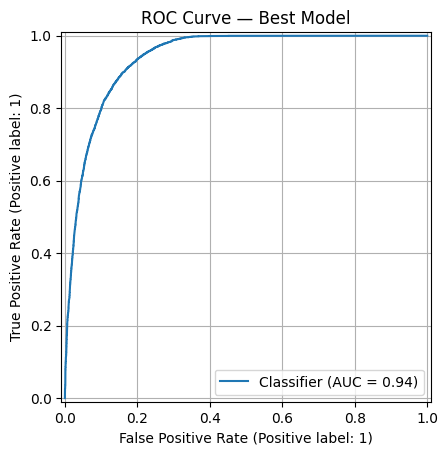

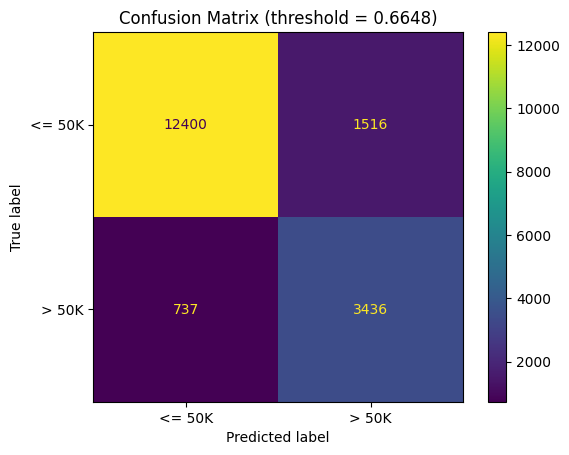

Classification Report (at chosen threshold):
              precision    recall  f1-score   support

      <= 50K      0.944     0.891     0.917     13916
       > 50K      0.694     0.823     0.753      4173

    accuracy                          0.875     18089
   macro avg      0.819     0.857     0.835     18089
weighted avg      0.886     0.875     0.879     18089



In [19]:
#@title Plot of ROC curve + Confusion matrix + Classification report for the selected model

import matplotlib.pyplot as plt
from sklearn.metrics import (
    RocCurveDisplay, ConfusionMatrixDisplay,
    confusion_matrix, classification_report
)

# 1) ROC curve (uses probabilities)
RocCurveDisplay.from_predictions(y_val, best_prob)
plt.title("ROC Curve — Best Model")
plt.grid(True)
plt.show()

# 2) Confusion matrix (at your chosen threshold)
cm = confusion_matrix(y_val, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["<= 50K", "> 50K"])
disp.plot(values_format="d")
plt.title(f"Confusion Matrix (threshold = {best_thr:.4f})")
plt.show()

# 3) Classification report (at your chosen threshold)
print("Classification Report (at chosen threshold):")
print(classification_report(y_val, y_pred, target_names=["<= 50K", "> 50K"], digits=3))


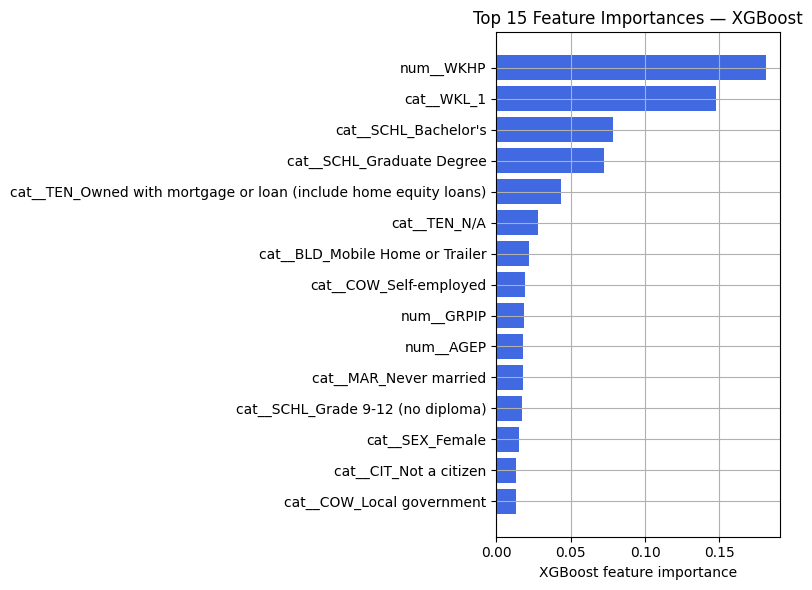

,feature,importance
0,num__WKHP,0.181561
1,cat__WKL_1,0.147678
2,cat__SCHL_Bachelor's,0.078659
3,cat__SCHL_Graduate Degree,0.072787
4,cat__TEN_Owned with mortgage or loan (include ...,0.043776
5,cat__TEN_N/A,0.027879
6,cat__BLD_Mobile Home or Trailer,0.021811
7,cat__COW_Self-employed,0.019684
8,num__GRPIP,0.018745
9,num__AGEP,0.018378


In [20]:
#@title Top-15 feature importances from the best XGB pipeline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Grab the fitted pipeline from your earlier grid search
xgb_pipe = gs_xgb.best_estimator_              # includes preprocessing + XGB
pre       = xgb_pipe.named_steps["pre"]        # ColumnTransformer
model     = xgb_pipe.named_steps.get("clf") or xgb_pipe.named_steps.get("model")

# Get feature names produced by the preprocessor (OHE + numerics)
feat_names = pre.get_feature_names_out()

# XGBoost importances aligned to input feature order:
importances = model.feature_importances_.ravel()

# Build top-15
topk = 15
order = np.argsort(importances)[::-1][:topk]
top_feats = pd.DataFrame({
    "feature": feat_names[order],
    "importance": importances[order]
})

# Plot
plt.figure(figsize=(8,6))
plt.barh(range(topk), top_feats["importance"][::-1], color='royalblue')
plt.yticks(range(topk), top_feats["feature"][::-1])
plt.xlabel("XGBoost feature importance")
plt.title("Top 15 Feature Importances — XGBoost")
plt.grid(True)
plt.tight_layout()
plt.show()

top_feats
